In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback')
import functions.data_wrangling as data
import functions.eddy_feedback as ef

# Functions

In [2]:
def pressure_scaling(da, p0=1e3, multiply_factor=True):
    
    """
        Converts log-pressure coordinates to pressure coordinates
        or visa versa.
        ----------------------------------------------------------
        
        Input: xr.DataArray in log-pressure/pressure coordinates
                - (pressure, latitude)
        
        Output: xr.DataArray in pressure/log-pressure coordinates
                - (pressure, latitude)
    """
    
    # define dimensions
    lat = da.lat.values
    level = da.level.values
    
    # define and calculate ratio
    p_ratio = np.repeat(level/p0, lat.size).reshape((level.size,lat.size))
    
    if multiply_factor:
        da_new = da * p_ratio
    else:
        da_new = da / p_ratio
        
    return da_new

In [3]:
def div_Fphi(ds, which_Fphi='EPF_phi_pr', apply_scaling=True, multiply_factor=True):
    
    """
        Calculate divergence of northward component
        of EP flux, F_phi. Including an optional 
        scaling from log-pressure to pressure coords.
        
        ----------------------------------------------
        
        Input: xr.Dataset containing epfy/Fy/Fphi [m3 s-2]
        
        Out: xr.DataArray Div_Fphi
    """
    
    # If required, check dimensions and variables are labelled correctly
    correct_dims = all(dim_name in ds.dims for dim_name in ['time', 'level', 'lat'])
    if not correct_dims:
        ds = data.check_dimensions(ds, ignore_dim='lon')
    
    # define DataArray
    Fphi = ds[which_Fphi]                                                       # [m3 s-2]
    
    if apply_scaling:
        Fphi = pressure_scaling(Fphi, multiply_factor=multiply_factor)
            
    
    # convert lat to radians take np.cos and multiply by Fphi (inside derivative)
    lat_rads = np.deg2rad(ds.lat.values)
    coslat = np.cos(lat_rads)  
    F_coslat = Fphi * coslat

    # calc derivative and convert lat dimension to radians
    F_coslat['lat'] = lat_rads
    deriv1 = F_coslat.differentiate('lat')                                      # [m2 s-2]
    
    # Divide by a cos(φ)
    a = 6.371e6
    div_Fphi = deriv1 / (a * coslat)                                            # [m s-2]
    
    # Divide by a cos(φ) AGAIN for whatever reason
    div_Fphi = div_Fphi / (a * coslat)                                          # [m s-2]
    
    return div_Fphi

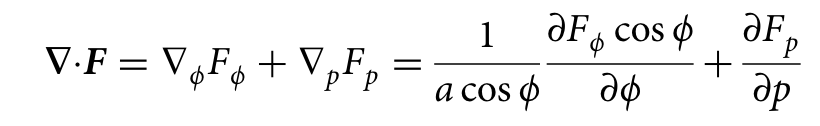

# SPARC SRIP Data

- EPF_phi_pr (epfy) = [m3 s-2]
- EPFD_phi_pr (div1) = [m s-2]

In [4]:
ep_fluxes = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/era_interim/TEM_monthly*')
ucomp = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/era_interim/ZMD_monthly*')

srip = xr.Dataset( {'EPF_phi_pr': ep_fluxes['EPF_phi_pr'], 'EPFD_phi_pr': ep_fluxes['EPFD_phi_pr'], 'ubar': ucomp.u } )
srip

<xarray.Dataset>
Dimensions:      (time: 456, pressure: 22, latitude: 73)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-14T09:00:00 ... 2016-12-14T09:...
  * pressure     (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude     (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
Data variables:
    EPF_phi_pr   (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_pr  (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    ubar         (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>

## Plot original variables

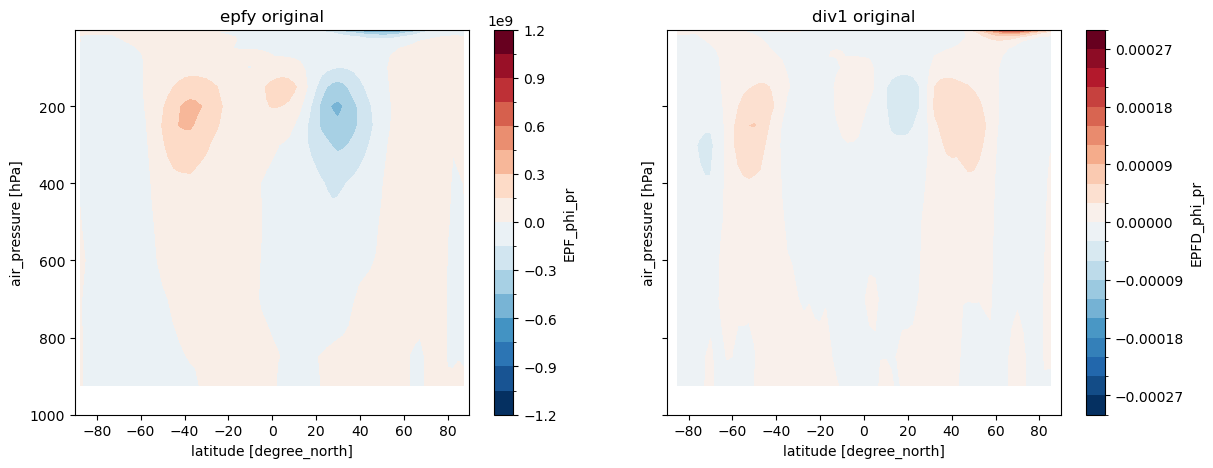

In [5]:
# calculate seasonal mean for orignal values
srip_NH = data.seasonal_mean(srip, season='djf')

# plot it
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
srip_NH.EPF_phi_pr.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_NH.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy original')
ax2.set_title('div1 original')
plt.show()

### Plot scaled versions of the originals

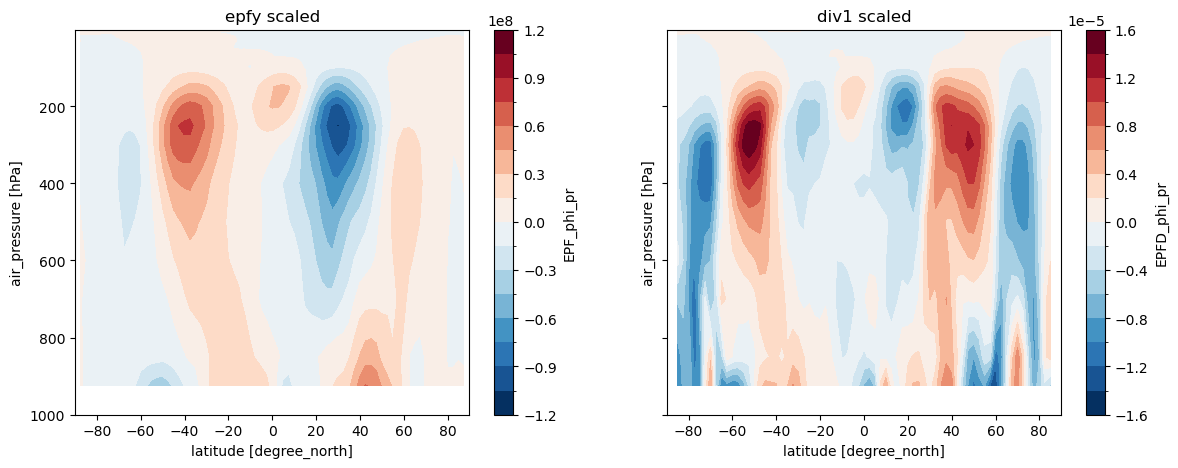

In [6]:
# scale variables epfy and divFy
srip_NH_scaled = data.seasonal_mean(srip, season='djf')
srip_NH_scaled['EPF_phi_pr'] = pressure_scaling(srip_NH_scaled['EPF_phi_pr'])
srip_NH_scaled['EPFD_phi_pr'] = pressure_scaling(srip_NH_scaled['EPFD_phi_pr'])

# plot it
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
srip_NH_scaled.EPF_phi_pr.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_NH_scaled.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy scaled')
ax2.set_title('div1 scaled')
plt.show()

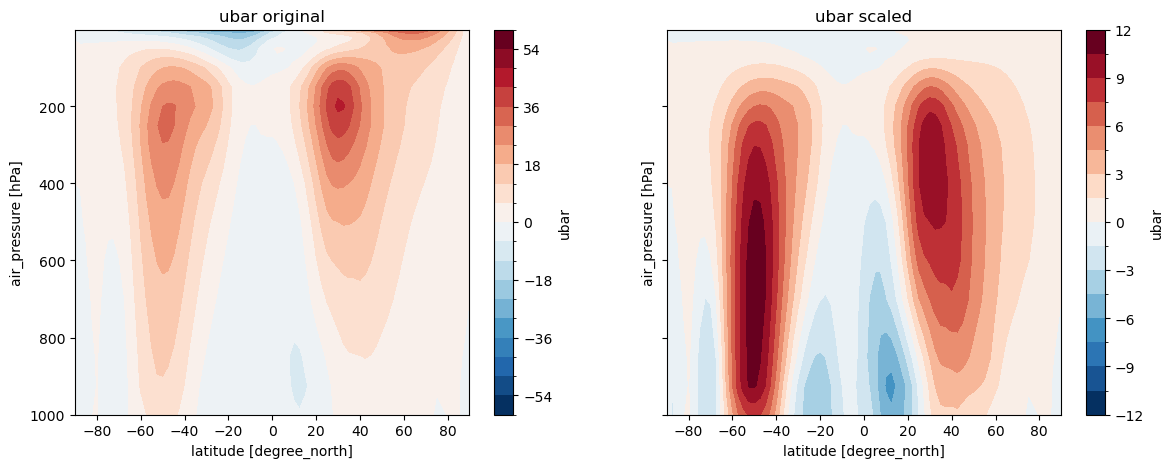

In [7]:
# calculate scaled version of ubar
ubar = srip_NH['ubar']
ubar = pressure_scaling(ubar)

# plot it
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
srip_NH.ubar.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
ubar.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('ubar original')
ax2.set_title('ubar scaled')
plt.show()

### Eddy Feedback

In [8]:
# calculate EFP for the original and scaled values of SRIP-calculated variables
efp_original = ef.calculate_efp(srip_NH, which_div1='EPFD_phi_pr')
efp_scaled = ef.calculate_efp(srip_NH_scaled, which_div1='EPFD_phi_pr')

print(f'EFP original: {efp_original} \nEFP scaled: {efp_scaled}')

EFP original: 0.4682 
EFP scaled: 0.4682


## Compare calculated variables

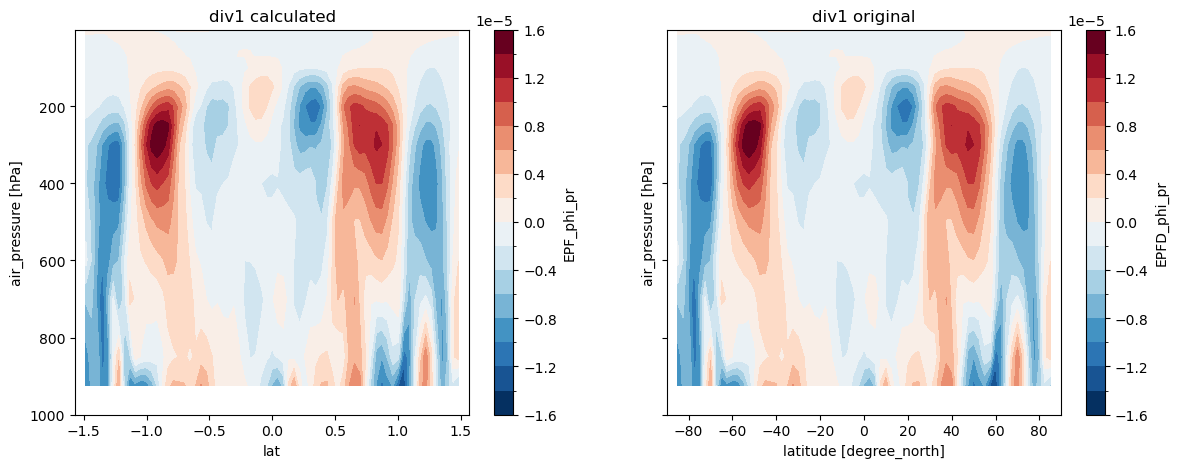

In [9]:
# pass epfy from SRIP dataset to calculate my own divFy
divF = div_Fphi(srip)
divF = data.seasonal_mean(divF, season='djf')

# Plot it
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
divF.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_NH_scaled.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('div1 calculated')
ax2.set_title('div1 original')
plt.show()

In [21]:
# test closeness of variables
np.testing.assert_allclose(divF.mean('time').values, srip_NH_scaled.EPFD_phi_pr.mean('time').values, rtol=1e-4)

### Eddy Feedback

In [10]:
efp_original = ef.calculate_efp(srip_NH, which_div1='EPFD_phi_pr')
efp_calculated = ef.calculate_efp(srip_NH_scaled, which_div1='EPFD_phi_pr')

print(f'EFP original: {efp_original} \nEFP scaled: {efp_scaled}')

EFP original: 0.4682 
EFP scaled: 0.4682


![DivF.png](DivF.png)

# Own Calculations using Daily data

In [11]:
# pull in files
ep_fluxes = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/TEM_monthly*')
ucomp = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/ZMD_monthly*')

# create subset of data and calculate seasonal mean
srip_jra = xr.Dataset( {'EPF_phi_pr': ep_fluxes['EPF_phi_pr'], 'EPFD_phi_pr': ep_fluxes['EPFD_phi_pr'], 'ubar': ucomp.u } )
srip_jra_djf = data.seasonal_mean(srip_jra, season='djf')
srip_jra_djf

<xarray.Dataset>
Dimensions:      (time: 58, level: 22, lat: 73)
Coordinates:
  * level        (level) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * lat          (lat) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * time         (time) datetime64[ns] 1958-12-01 1959-12-01 ... 2015-12-01
Data variables:
    EPF_phi_pr   (time, level, lat) float32 nan nan nan nan ... nan nan nan nan
    EPFD_phi_pr  (time, level, lat) float32 nan nan nan nan ... nan nan nan nan
    ubar         (time, level, lat) float32 3.844e-05 -2.151 ... -5.338e-05

In [23]:
jra = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/jra55_daily/jra55_uvtw_ubar_ep.nc',
                        parallel=True, chunks={'time':31})
jra = jra[['u', 'ep1', 'div1']]
jra = jra.sel(level=srip_jra_djf.level.values)
jra['ubar'] = jra.u.mean('lon')

# epfy has units m3 s-2
lat_rads = np.deg2rad(jra.lat.values)
coslat = np.cos(lat_rads)  
a = 6.371e6
jra['epfy'] = jra.ep1 * (a * coslat) 

# divFy has units m s-2
jra['divFy'] = jra['div1'] / 86400

# subset dataset to match SRIP
jra = jra.where(jra.level < 1000)
jra = jra.where(jra.level > 1)
jra = jra.where(jra.lat >= -87.5)
jra = jra.where(jra.lat <= 87.5)

jra_djf = data.seasonal_mean(jra, season='djf')
jra_djf

In [ ]:
jra_djf.to_netcdf('jra_djf_matching-SRIP.nc')

### Compare to SRIP with adjustments and further calculations

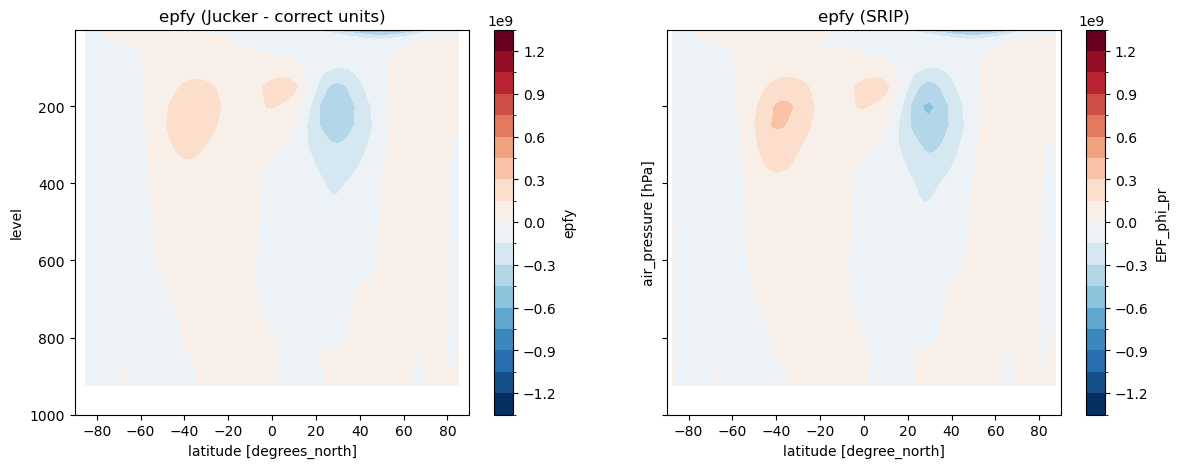

In [ ]:
# plot epfy (ep1 * acos(phi)) to have same units [m3 s-2]
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

jra_djf.epfy.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_jra_djf.EPF_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)

ax1.set_title('epfy (Jucker - correct units)')
ax2.set_title('epfy (SRIP)')
plt.show()

In [ ]:
# test closeness of variables
np.testing.assert_allclose(jra_djf.epfy.mean('time').values, srip_jra_djf.EPF_phi_pr.mean('time').values)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

x and y nan location mismatch:
 x: array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,   445420.165537, ...,...
 y: array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,  8.234766e+05, -1.396498e+06, ...,  5.892215e+05,...

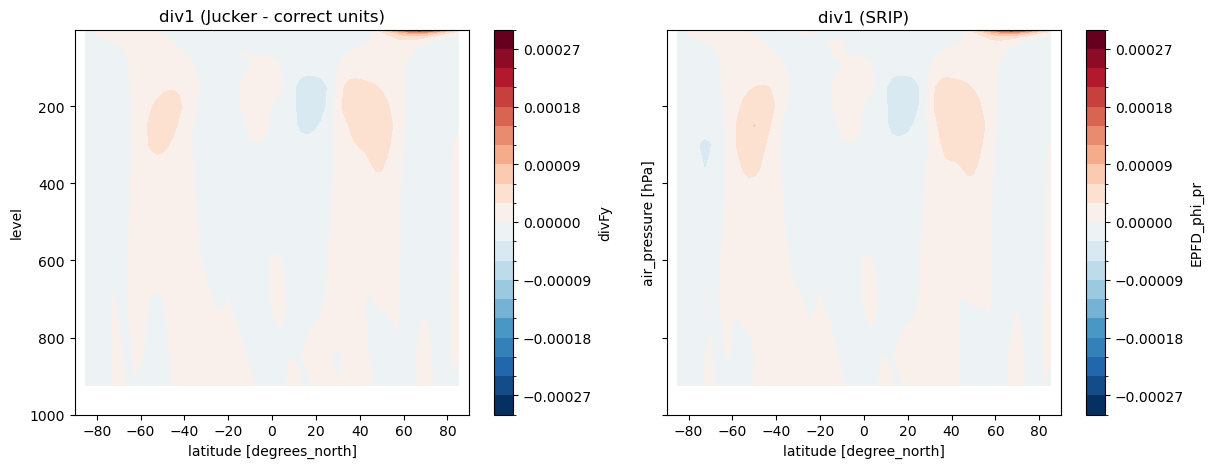

In [ ]:
# plot divFy (div1 / 86400) to have same units [m s-2]
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

jra_djf.divFy.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_jra_djf.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)

ax1.set_title('div1 (Jucker - correct units)')
ax2.set_title('div1 (SRIP)')
plt.show()

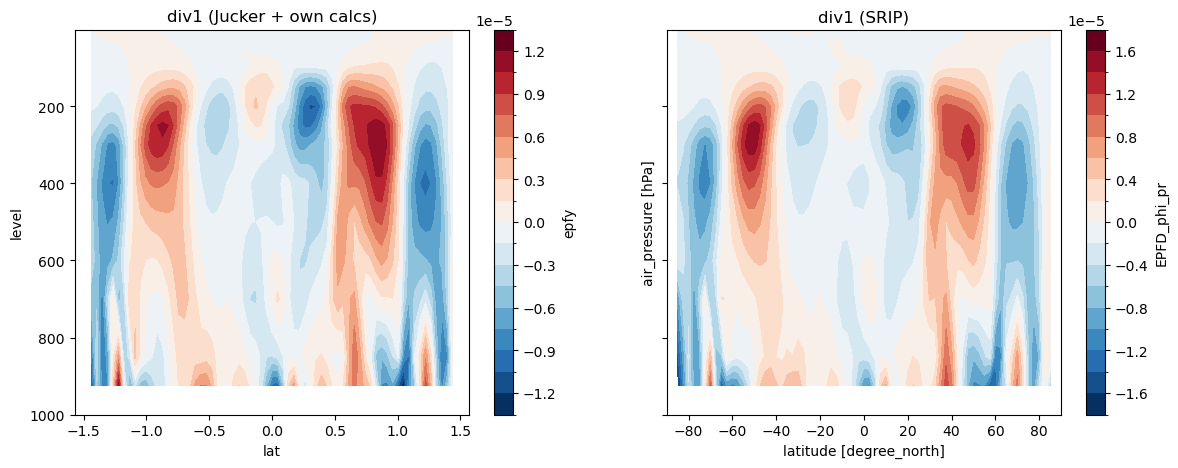

In [ ]:
srip_jra_djf_scaled = data.seasonal_mean(srip_jra, season='djf')
srip_jra_djf_scaled['EPF_phi_pr'] = pressure_scaling(srip_jra_djf_scaled['EPF_phi_pr'])
srip_jra_djf_scaled['EPFD_phi_pr'] = pressure_scaling(srip_jra_djf_scaled['EPFD_phi_pr'])

jra_divF = div_Fphi(jra, which_Fphi='epfy')
jra_divF = data.seasonal_mean(jra_divF, season='djf')

# plot it
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

jra_divF.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_jra_djf_scaled.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)

ax1.set_title('div1 (Jucker + own calcs)')
ax2.set_title('div1 (SRIP)')
plt.show()

### Eddy Feedback Parameter

In [ ]:
efp_srip_original = ef.calculate_efp(srip_jra_djf, which_div1='EPFD_phi_pr')
efp_srip_scaled = ef.calculate_efp(srip_jra_djf_scaled, which_div1='EPFD_phi_pr')

print(f'EFP original (SRIP): {efp_srip_original} \nEFP scaled (SRIP): {efp_srip_scaled}')

EFP original (SRIP): 0.4646 
EFP scaled (SRIP): 0.4646


In [ ]:
efp_me_original = ef.calculate_efp(jra_djf, which_div1='divFy')

jra_djf['divFphi'] = jra_divF
efp_me_calculated = ef.calculate_efp(jra_djf, which_div1='divFy')

print(f'EFP original: {efp_me_original} \nEFP calculated: {efp_me_calculated}')

EFP original: 0.3962 
EFP calculated: 0.3962


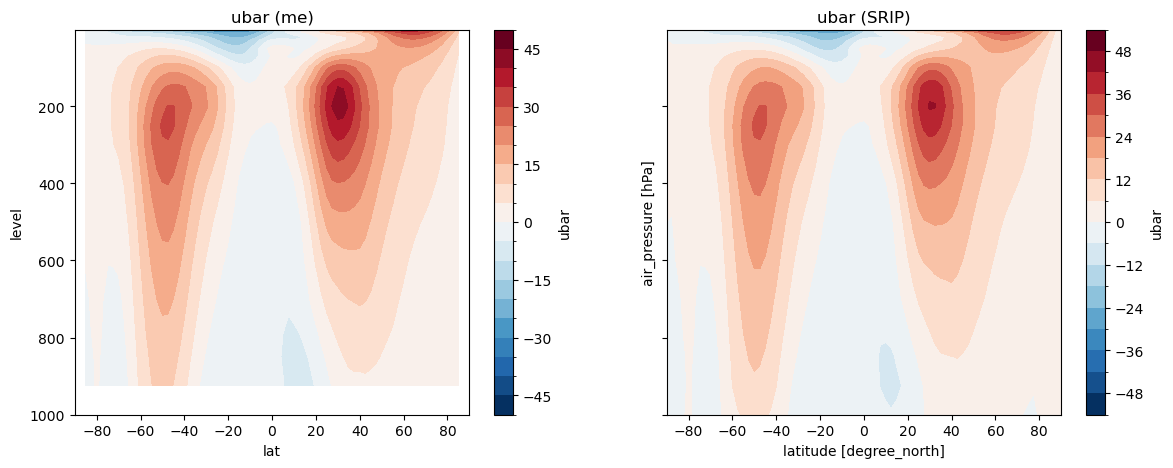

In [ ]:
# plot ubar
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

jra_djf.ubar.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_jra_djf.ubar.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)

ax1.set_title('ubar (me)')
ax2.set_title('ubar (SRIP)')
plt.show()